Anchors for MNIST

In [3]:
!pip install alibi

     |████████████████████████████████| 225kB 8.8MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 327kB 27.8MB/s 
     |████████████████████████████████| 204kB 42.1MB/s 
     |████████████████████████████████| 28.0MB 151kB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456458 sha256=85eca86c6d0633cc520c326fb6aaf24e580b8352960b8fd0ce09ae7cc758b950
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052144 sha256=cd88b8db4a763fcf6583ad0c93b3b1d2ec9d4ec3dfac698c349e40fe09798ae8
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built shap spacy-lookups-data


In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import AnchorImage

In [66]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


In [67]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

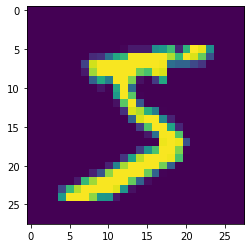

In [68]:
idx = 0
plt.imshow(x_train[idx]);

In [69]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [70]:
def model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [71]:
cnn = model()
cnn.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 32)         

In [72]:
cnn.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
938/938 [==============================] - 57s 61ms/step - loss: 0.3349 - accuracy: 0.8947
Epoch 2/3
938/938 [==============================] - 57s 61ms/step - loss: 0.1213 - accuracy: 0.9625
Epoch 3/3
938/938 [==============================] - 57s 60ms/step - loss: 0.0950 - accuracy: 0.9709


In [77]:
# Evaluate the model on test set
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.9873999953269958


In [78]:
def superpixel(image, size=(4, 7)):
    segments = np.zeros([image.shape[0], image.shape[1]])
    row_idx, col_idx = np.where(segments == 0)
    for i, j in zip(row_idx, col_idx):
        segments[i, j] = int((image.shape[1]/size[1]) * (i//size[0]) + j//size[1])
    return segments

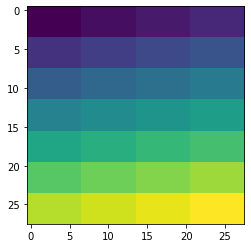

In [79]:
segments = superpixel(x_train[idx])
plt.imshow(segments);

In [80]:
predict_fn = lambda x: cnn.predict(x)

In [81]:
image_shape = x_train[idx].shape
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=superpixel)

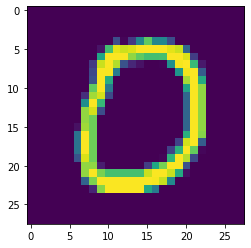

In [82]:
i = 10
image = x_test[i]
plt.imshow(image[:,:,0]);

In [83]:
cnn.predict(image.reshape(1, 28, 28, 1)).argmax()

0

In [84]:
explanation = explainer.explain(image, threshold=.95, p_sample=.8, seed=0)

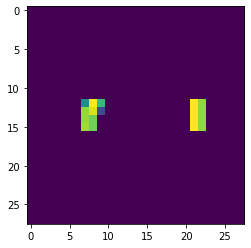

In [85]:
plt.imshow(explanation.anchor[:,:,0]);